# Digital Signal and Image Management

## Assignment 4

Implementare una rete neurale per la classificazione del dataset MNIST a partire dalle istruzioni viste ad esercitazione.

Seguire la seguente struttura:

* Convoluzione bidimensionale con 32 filtri 3×3
* ReLU
* Max pooling bidimensionale con filtro 2×2
* Flattening
* Fully-connected che mappi a 128 dimensioni
* ReLU
* Fully-connected che mappi alla dimensione finale del problema

### Packages

Innanzitutto importiamo i pacchetti necessari.

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (Dense, Input, Dropout, Flatten,
                         BatchNormalization, MaxPooling2D, Conv2D, ReLU, Softmax)
from keras.datasets import mnist
from keras.utils import to_categorical
from livelossplot.keras import PlotLossesCallback
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Importiamo il dataset **MNIST**.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Verifichiamo le dimensionalità.

In [3]:
print("X train shape:{}\nX test shape:{}".format(x_train.shape, x_test.shape))

X train shape:(60000, 28, 28)
X test shape:(10000, 28, 28)


Plottiamo degli esempi:

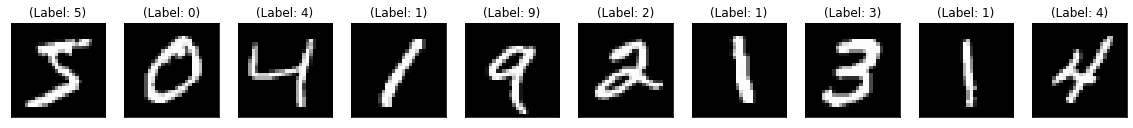

In [4]:
plt.figure(figsize = (20,15))
n = 10
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i], cmap = "gray")
    plt.title("(Label: " + str(y_train[i]) + ")")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Aggiungiamo alle nostre immagini, sotto forma di *np.arrays*, una dimensione ulteriore per indicare la quantità di canali presenti.

In [5]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)

print("X train shape:{}\nX test shape:{}".format(x_train.shape, x_test.shape))

X train shape:(60000, 28, 28, 1)
X test shape:(10000, 28, 28, 1)


A questo punto provvediamo a castare le nostre immagini in formato a virgola mobile ed a riscalare il valore dei pixel dall'iniziale *range* [0, 255] al nuovo [0, 1].

In [6]:
print("Original X train max:{}\nOriginal X test max:{}".format(np.max(x_train), np.max(x_test)))

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

print("New X train max:{}\nNew X test max:{}".format(np.max(x_train), np.max(x_test)))

Original X train max:255
Original X test max:255
New X train max:1.0
New X test max:1.0


A questo punto non ci resta che convertire il formato delle nostre etichette in *one-hot encoding* per permettere la classificazione *multilabel*.

In [7]:
print("Old y format example: {}".format(y_train[0]))

num_classes = 10
y_train = to_categorical(y_train, num_classes)

print("New y format example: {}".format(y_train[0]))

Old y format example: 5
New y format example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


A questo punto siamo pronti a realizzare la nostra rete.

Iniziamo inizializzando alcuni iper-parametri come *batch size*, numero di epoche ed inizializzando il formato delle immagini che andranno in input alla nostra rete.

In [8]:
batch_size = 2048
epochs = 10
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
num_classes = y_train.shape[1]

A questo punto definiamo il corpo vero e proprio del nostro modello utilizzando però la struttura Model invece di quella Sequential, seguendo le specifiche di consegna:

In [9]:
def init_model(input_img):
    conv1 = Conv2D(32, (3, 3))(input_img)
    act1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 1)(act1)
    flat = Flatten()(pool1)
    fc1 = Dense(128)(flat)
    act2 = ReLU()(fc1)
    fc2 = Dense(num_classes)(act2)
    out = Softmax()(fc2)
    return out

Procediamo infine ad inizializzare il modello e a compilarlo specificando loss function, ottimizzatore e metrica aggiuntiva.

In [10]:
full_model = Model(input_img, init_model(input_img))

full_model.compile(loss = 'categorical_crossentropy',
                   optimizer = 'adam',
                   metrics=['acc'])

full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2560128   
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128)               0   

Il nostro modello contiene ~ 2.500.000 parametri, ciò è dovuto alla numerosità dei neuroni del primo layer fully connected. Un numero tale di neuroni infatti porta all'esplosione dei parametri totali da stimare poichè ogni pixel residuo dopo il processo di max pooling sarà connesso ad ogni neurone.

Specifichiamo a questo punto le ultime istruzioni, tra questo l'utilizzo di un validation set pari al 10% del training set e l'utilizzo di una callback personalizzata per plottare in streaming le prestazioni del modello oltre alla produzione di un report riguardante i valori min, max e current di loss e accuracy sia per quanto riguarda il training set, sia il validation set.

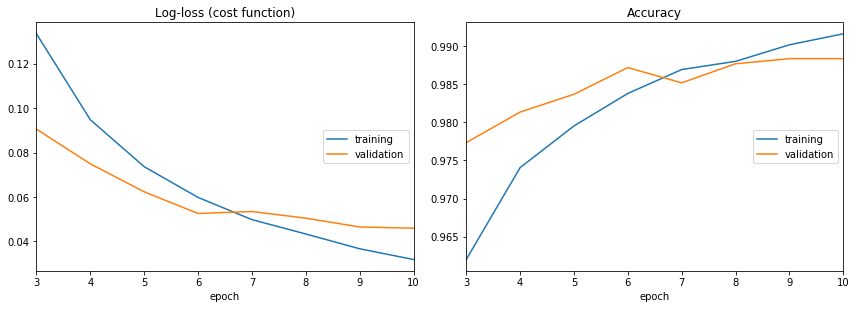

Log-loss (cost function):
training   (min:    0.032, max:    0.589, cur:    0.032)
validation (min:    0.046, max:    0.201, cur:    0.046)

Accuracy:
training   (min:    0.829, max:    0.992, cur:    0.992)
validation (min:    0.942, max:    0.988, cur:    0.988)


In [11]:
trained = full_model.fit(x_train, y_train, 
                        batch_size = batch_size, epochs = epochs,
                        verbose = 0, validation_split = .1, use_multiprocessing = True,
                        callbacks = [PlotLossesCallback()])

Per concludere produciamo un classification report per verificare le prestazioni del nostro modello sul test set.

In [12]:
y_pred = full_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9749    0.9898    0.9823       980
           1     0.9930    0.9930    0.9930      1135
           2     0.9844    0.9767    0.9805      1032
           3     0.9921    0.9891    0.9906      1010
           4     0.9898    0.9857    0.9878       982
           5     0.9887    0.9832    0.9859       892
           6     0.9833    0.9843    0.9838       958
           7     0.9732    0.9893    0.9812      1028
           8     0.9865    0.9743    0.9804       974
           9     0.9782    0.9772    0.9777      1009

    accuracy                         0.9844     10000
   macro avg     0.9844    0.9843    0.9843     10000
weighted avg     0.9844    0.9844    0.9844     10000



Come si può vedere le prestazioni sono molto elevate, ma ciò è dovuto alla sostanziale semplicità della classificazione, poichè il MNIST è considerabile un dataset "giocattolo".